In [0]:
!mkdir train
!cp train.zip train/
!unzip train/train.zip -d train

!mkdir test
!cp test.zip test/
!rm train.zip test.zip
!unzip test/test.zip -d test
!rm train/train.zip
!rm test/test.zip

In [0]:
import os 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras.preprocessing import image
from keras import models, layers 
from keras import callbacks
from keras.applications import Xception
import cv2
import time

Using TensorFlow backend.


In [0]:
!ls 

class.csv  sample_data		  test	    train
drive	   sample_submission.csv  test.csv  train.csv


In [0]:
!rm -r /content/train_chop

In [0]:
train_df = pd.read_csv('train.csv')
train_df.head()
train_df['class'] = train_df['class'].astype(str)

In [0]:
img = cv2.imread(f'/content/train/{train_df.iloc[0, 0]}')

In [0]:
img.shape

(500, 700, 3)

In [0]:
def chop_img(data_type, path_df, margin = 15):
  """
     ex) chip_img('trian', train_df, margin = 20)
     
     data_type = train or test as string         
     path_df = train_df or test_df,
     marging = how many pixel left over 
     
     this function create directory as data_type_chop """
  
  if f'{data_type}_chop' in os.listdir('/content/'):
    os.removedirs(f'{data_type}_chop')
  else:
    os.mkdir(f'{data_type}_chop')                                            # make directory
    
  for i in range(len(path_df.img_file)):
    img = cv2.imread(f'/content/{data_type}/{path_df.iloc[i, 0]}')               # load image
    cv2.waitKey(0)
    
    crop_img = img[path_df.iloc[i, 2] : path_df.iloc[i, 4] ,     # y : y + h
                   path_df.iloc[i,1] : path_df.iloc[i, 3]]     # x : x + w

    cv2.imwrite(f'/content/{data_type}_chop/{path_df.iloc[i,0]}', crop_img)  # save the image
    
    cv2.waitKey(0)

In [0]:
chop_img('train', train_df)

In [0]:
train_gen = image.ImageDataGenerator(rescale = 1./255, rotation_range = 40, 
                                     width_shift_range = 0.3, 
                                     height_shift_range=0.3, 
                                     shear_range = 0.3, 
                                     zoom_range = 0.3, 
                                     horizontal_flip = True,
                                     vertical_flip = True,
                                     validation_split = 0.2
                                    )

In [0]:
train_data = train_gen.flow_from_dataframe(train_df, '/content/train_chop', x_col = "img_file", y_col = "class", target_size=(225,225), class_mode='categorical', subset='training', batch_size=20)

valid_data = train_gen.flow_from_dataframe(train_df, '/content/train_chop', x_col = "img_file", y_col = "class", target_size=(225,225), class_mode='categorical', subset='validation', batch_size=20)

Found 8013 validated image filenames belonging to 196 classes.
Found 2003 validated image filenames belonging to 196 classes.


## Chekcing flow from dataframe

In [0]:
j = 0
for i in train_gen.flow_from_dataframe(train_df, '/content/train_chop', x_col = "img_file", y_col = "class", target_size=(225,225), class_mode='categorical', subset='training', batch_size=1):
  print(i)
  print(i[0].shape)
  j += 1
  if j % 2 == 0:
    break

Found 8013 validated image filenames belonging to 196 classes.
(array([[[[0.53522116, 0.52345645, 0.49600545],
         [0.547006  , 0.5352413 , 0.5077903 ],
         [0.55879086, 0.54702616, 0.5195752 ],
         ...,
         [0.60784316, 0.60784316, 0.6       ],
         [0.60784316, 0.60784316, 0.6       ],
         [0.60784316, 0.60784316, 0.6       ]],

        [[0.5323684 , 0.5206037 , 0.49315268],
         [0.5441533 , 0.53238857, 0.5049376 ],
         [0.5559382 , 0.5441734 , 0.51672244],
         ...,
         [0.60784316, 0.60784316, 0.6       ],
         [0.60784316, 0.60784316, 0.6       ],
         [0.60784316, 0.60784316, 0.6       ]],

        [[0.5295156 , 0.5177509 , 0.49029994],
         [0.5413005 , 0.5295358 , 0.5020848 ],
         [0.5530854 , 0.5413207 , 0.51386964],
         ...,
         [0.60784316, 0.60784316, 0.6       ],
         [0.60784316, 0.60784316, 0.6       ],
         [0.60784316, 0.60784316, 0.6       ]],

        ...,

        [[0.43529415, 0.4470

In [0]:
os.listdir('/content/train_chop')[0]

'train_06631.jpg'

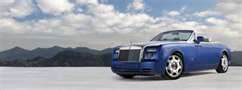

In [0]:
image.load_img(f"/content/train/train_06744.jpg")

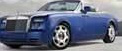

In [0]:
image.load_img(f"/content/train_chop/train_06744.jpg")

In [0]:
train_df.iloc[6743, :]

img_file    train_06744.jpg
bbox_x1                 113
bbox_y1                  30
bbox_x2                 235
bbox_y2                  81
class                   175
Name: 6743, dtype: object

Model - Xception

In [0]:
xception_model = Xception(include_top = False, 
                          input_shape = (225, 225, 3))

In [0]:
xception_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 225, 225, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 112, 112, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 112, 112, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 112, 112, 32) 0           block1_conv1_bn[0][0]            
__________________________________________________________________________________________________
block1_con

In [0]:
from keras.utils import plot_model

In [0]:
plot_model(xception_model, 'xception_model.png')
model_plotting = plt.imread('xception_model.png')


In [0]:
check_points = callbacks.ModelCheckpoint('car_clf.h5', monitor = 'val_loss', save_best_only=True)

In [0]:
model_ex = models.Sequential()
model_ex.add(xception_model)
model_ex.add(layers.AvgPool2D(2,2, name = 'Avg_pool'))
model_ex.add(layers.Flatten(name = 'Flat'))
model_ex.add(layers.Dense(1024, activation = 'relu', name = 'Dense_1'))
model_ex.add(layers.Dense(196, activation = 'softmax', name = 'Dense_out'))

model_ex.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Model)             (None, 7, 7, 2048)        20861480  
_________________________________________________________________
Avg_pool (AveragePooling2D)  (None, 3, 3, 2048)        0         
_________________________________________________________________
Flat (Flatten)               (None, 18432)             0         
_________________________________________________________________
Dense_1 (Dense)              (None, 1024)              18875392  
_________________________________________________________________
Dense_out (Dense)            (None, 196)               200900    
Total params: 39,937,772
Trainable params: 39,883,244
Non-trainable params: 54,528
_________________________________________________________________


In [0]:
plot_model(model_ex, 'full_model.png')
model_plotting = plt.imread('full_model.png')

In [0]:
model_ex.compile(loss='categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [0]:
exception_net_history = model_ex.fit_generator(train_data, steps_per_epoch= 8013//20, epochs = 100, validation_data=valid_data, validation_steps=2003//20, callbacks=[check_points])

Epoch 1/100
400/400 [==============================] - 210s 525ms/step - loss: 5.2821 - acc: 0.0073 - val_loss: 5.2792 - val_acc: 0.0065
Epoch 2/100
400/400 [==============================] - 200s 501ms/step - loss: 5.2770 - acc: 0.0089 - val_loss: 5.2812 - val_acc: 0.0066
Epoch 3/100
400/400 [==============================] - 202s 505ms/step - loss: 5.2856 - acc: 0.0091 - val_loss: 7.7147 - val_acc: 0.0055
Epoch 4/100
400/400 [==============================] - 203s 509ms/step - loss: 5.2756 - acc: 0.0089 - val_loss: 7.5881 - val_acc: 0.0066
Epoch 5/100
400/400 [==============================] - 203s 508ms/step - loss: 5.2250 - acc: 0.0110 - val_loss: 5.3954 - val_acc: 0.0091
Epoch 6/100
400/400 [==============================] - 203s 508ms/step - loss: 5.1711 - acc: 0.0118 - val_loss: 5.2273 - val_acc: 0.0116
Epoch 7/100
400/400 [==============================] - 204s 509ms/step - loss: 5.1486 - acc: 0.0138 - val_loss: 5.1576 - val_acc: 0.0126
Epoch 8/100
400/400 [====================

KeyboardInterrupt: ignored